# Lstm Using amazon fine food reviews

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 130000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (130000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(111488, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

85.76

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(111486, 10)


1    93593
0    17893
Name: Score, dtype: int64

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR chee

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
The tree came with no problems. It was packed well, no issues with the packaging or anything, it was all perfectly intact. It is very healthy, with a ton of buds and has no problems whatsoever. Fancy fancy little tree.
First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that's not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.Secondly, after tasting Aunt Lizzie's cheese straws for the first time this Fall, I will not eat anyone else's. I literally threw away a package of a VERY POPULAR cheese straw com

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First of all, I would like to comment regarding previous reviews. I do not think the first review in 2005 was done by an employee, and that is not really a fair statement but rather an assumption lacking any real fact or evidence. It seems like a very small company that just enjoys making cheese straws and wants to share them with others. I sincerely doubt that, at the great price they are, the company even makes a ton of profit - which is a shame.<br /><br />Secondly, after tasting Aunt Lizzie is cheese straws for the first time this Fall, I will not eat anyone else is. I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them, they just tasted bland and floury. I could not even bring myself to finish them. I crave Aunt Lizzie is cheese straws so much. (I recommend trying them with some Shiraz or other wine!)<br /><br />Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year, 

In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First of all I would like to comment regarding previous reviews I do not think the first review in 2005 was done by an employee and that is not really a fair statement but rather an assumption lacking any real fact or evidence It seems like a very small company that just enjoys making cheese straws and wants to share them with others I sincerely doubt that at the great price they are the company even makes a ton of profit which is a shame br br Secondly after tasting Aunt Lizzie is cheese straws for the first time this Fall I will not eat anyone else is I literally threw away a package of a VERY POPULAR cheese straw company that I received yesterday as a gift because when I tasted them they just tasted bland and floury I could not even bring myself to finish them I crave Aunt Lizzie is cheese straws so much I recommend trying them with some Shiraz or other wine br br Our company gave out Aunt Lizzie is cheese straws as a corporate customer gift this year and I bet that Aunt Lizzie will

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 111486/111486 [00:37<00:00, 2948.07it/s]


In [25]:
final['CleanedText']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
70685,76879,B00002N8SM,A2579IQYG8Y9YF,Cynthia,0,0,1,1244332800,Works Great!,"Having used traditional fly rolls in the past,...",used traditional fly rolls past dubious hubby ...
70686,76880,B00002N8SM,A1S64UB4EOYFTK,Heather Paradee,0,0,1,1231027200,Prettier than fly paper,Well I received the item and placed it in the ...,well received item placed area put fly paper f...
70666,76859,B00002N8SM,A88YOFJG6IPOZ,duane,0,0,0,1343433600,RIpoff,What a horrible product. First of all the item...,horrible product first item not work week lots...


### Count no. of words in the Vocabulary

In [26]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# Finding all words in the vocabulary
count_vect = CountVectorizer() 
count_vect.fit(x)

vocabulary = count_vect.get_feature_names()
print('No. of words in the Vocabulary : ',len(vocabulary))

No. of words in the Vocabulary :  62333


In [0]:
# Storing all words in the dictionary (words as keys and index as values)
corpus = dict()
ind = 0
for sent in x:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

# Getting frequency for each word of vocabulary and storing it in a list
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

In [0]:
# Getting Index for each word in the vocabulary
# Sorting frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

# Allocating ranks to words of vocabulary in decreasing order of frequency and storing words in a dictionary
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [0]:
# Converting full data into imdb format
data = []
for sent in x:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

# Splitting the data into 50-50 train_data and test_data
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.5, random_state=42)

In [30]:
print("No. of datapoints in X_train :",len(X_train))
print("No. of datapoints in X_test :",len(X_test))
print("Shape of Y_train :",Y_train.shape)
print("Shape of Y_test :",Y_test.shape)

No. of datapoints in X_train : 55743
No. of datapoints in X_test : 55743
Shape of Y_train : (55743,)
Shape of Y_test : (55743,)


In [31]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [32]:
# truncate and/or pad input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(55743, 100)
[  204   114  1799  1403  2257   312  3924   345    59   234   636   312
     5  2008  3074   318   730   864   446  3851   121   197    84  1077
   312    50  1435    41   546    72   307   997    72   312   403   592
  2047   312   332    99    35     2   386  9160   381   312   307   997
    81     6    32     1  5459     1   297   312  1042   307   115   114
   330   192   773   312   642   332   174  1565   312    36 15260    75
   140    75   140 11519   312    30   307   811   307  5536  3074     6
   357   442   312   307     3   312    19     3   983  2461   546   307
   997   633   592   312]


In [0]:
# this function is used draw Binary Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

 ### with 1 LSTM layer

In [56]:
import warnings
warnings.filterwarnings("ignore")
# create the model
embedding_vecor_length = 32

# Initialising the model
model_1 = Sequential()

# Adding embedding
model_1.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding Dropout
model_1.add(Dropout(1.0))

# Adding first LSTM layer
model_1.add(LSTM(100))

# Adding Dropout
model_1.add(Dropout(1.5))

# Adding output layer
model_1.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_1.summary())

# Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_1 = model_1.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 32)           1994656   
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 2,047,957
Trainable params: 2,047,957
Non-trainable params: 0
_________________________________________________________________
None
Train on 55743 samples, validate on 55743 samples
Epoch 1/10
55743/55743 [==============================] - 29s 512us/step - lo

Accuracy: 98.96%


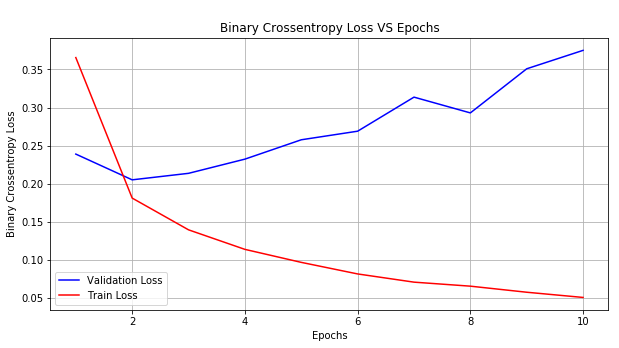

In [57]:
# Final evaluation of the model
scores = model_1.evaluate(X_train, Y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_1_test = scores[1]
#model_1_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

### with 2 LSTM layers

In [58]:
import warnings
warnings.filterwarnings("ignore")
# create the model
embedding_vecor_length = 32

# Initialising the model
model_2 = Sequential()

# Adding embedding
model_2.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_2.add(LSTM(100,return_sequences=True, dropout=1.5, recurrent_dropout=1.5))

# Adding second LSTM layer
model_2.add(LSTM(100, dropout=1.6, recurrent_dropout=1.6))

# Adding output layer
model_2.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_2.summary())

# Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_2 = model_2.fit(X_train, Y_train, nb_epoch=10, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 32)           1994656   
_________________________________________________________________
lstm_24 (LSTM)               (None, 100, 100)          53200     
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 2,128,357
Trainable params: 2,128,357
Non-trainable params: 0
_________________________________________________________________
None
Train on 55743 samples, validate on 55743 samples
Epoch 1/10
55743/55743 [==============================] - 51s 922us/step - loss: 0.3462 - acc: 0.8679 - val_loss: 0.2181 - val_acc: 0.9141
Epoch 2/10
55743/55743 [==============================] - 46s 823us/st

Accuracy: 99.26%


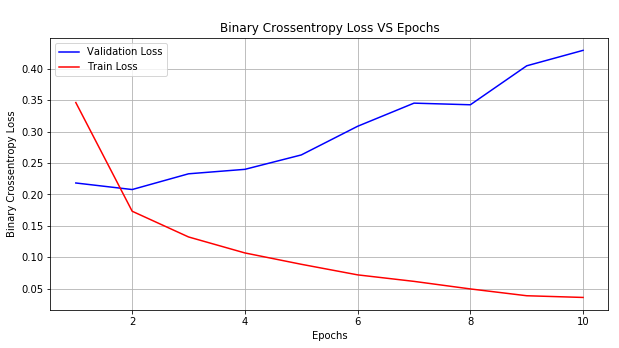

In [59]:
# Final evaluation of the model
scores1 = model_2.evaluate(X_train, Y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))

# Test and train accuracy of the model
model_2_test = scores[1]
model_2_train = max(history_2.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x1 = list(range(1,11))

# Validation loss
vy = history_2.history['val_loss']
# Training loss
ty = history_2.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

### With 3 LSTM Layers

In [60]:
# create the model
embedding_vecor_length = 32

# Initialising the model
model_3 = Sequential()

# Adding embedding
model_3.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=1.8, recurrent_dropout=1.8))

# Adding second LSTM layer
model_3.add(LSTM(100,return_sequences=True, dropout=2.0, recurrent_dropout=2.0))

# Adding third LSTM layer
model_3.add(LSTM(100, dropout=2.2, recurrent_dropout=2.2))

# Adding output layer
model_3.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_3.summary())

# Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_3 = model_3.fit(X_train, Y_train, nb_epoch=7, batch_size=1024 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 32)           1994656   
_________________________________________________________________
lstm_26 (LSTM)               (None, 100, 100)          53200     
_________________________________________________________________
lstm_27 (LSTM)               (None, 100, 100)          80400     
_________________________________________________________________
lstm_28 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 2,208,757
Trainable params: 2,208,757
Non-trainable params: 0
_________________________________________________________________
None
Train on 55743 samples, validate on 55743 samples
Epoch 1/7
55743/55743 [==============================] - 42s 753us/step - los

Accuracy: 98.67%


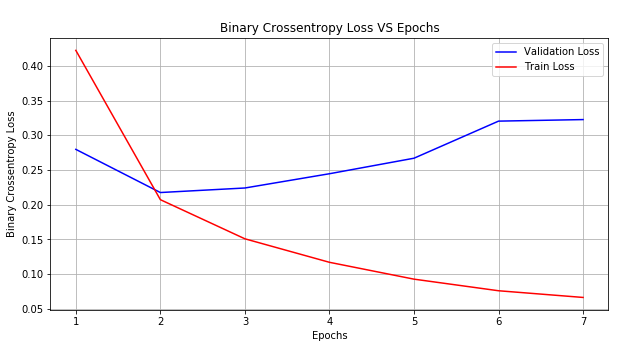

In [61]:
# Final evaluation of the model
scores = model_3.evaluate(X_train, Y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_3_test = scores[1]
#model_3_train = max(history_3.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,8))

# Validation loss
vy = history_3.history['val_loss']
# Training loss
ty = history_3.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## RNN with 4 LSTM layers

In [62]:
# create the model
embedding_vecor_length = 64

# Initialising the model
model_4 = Sequential()

# Adding embedding
model_4.add(Embedding(len(vocabulary), embedding_vecor_length, input_length=max_review_length))

# Adding first LSTM layer
model_4.add(LSTM(120,return_sequences=True, dropout=2.6, recurrent_dropout=2.6))

# Adding second LSTM layer
model_4.add(LSTM(100,return_sequences=True, dropout=2.5, recurrent_dropout=2.5))

# Adding third LSTM layer
model_4.add(LSTM(80,return_sequences=True, dropout=2.4, recurrent_dropout=2.4))

# Adding fourth LSTM layer
model_4.add(LSTM(60, dropout=2.3, recurrent_dropout=2.3))

# Adding output layer
model_4.add(Dense(1, activation='sigmoid'))

# Printing the model summary
print(model_4.summary())

# Compiling the model
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the data to the model
history_4 = model_4.fit(X_train, Y_train, nb_epoch=8, batch_size=2048 ,verbose=1,validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 64)           3989312   
_________________________________________________________________
lstm_29 (LSTM)               (None, 100, 120)          88800     
_________________________________________________________________
lstm_30 (LSTM)               (None, 100, 100)          88400     
_________________________________________________________________
lstm_31 (LSTM)               (None, 100, 80)           57920     
_________________________________________________________________
lstm_32 (LSTM)               (None, 60)                33840     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 61        
Total params: 4,258,333
Trainable params: 4,258,333
Non-trainable params: 0
_________________________________________________________________


Accuracy: 98.12%


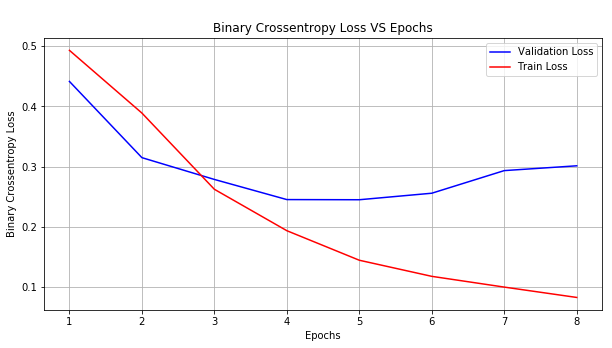

In [63]:
# Final evaluation of the model
scores = model_4.evaluate(X_train, Y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Test and train accuracy of the model
model_4_test = scores[1]
#model_4_train = max(history_4.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,9))

# Validation loss
vy = history_4.history['val_loss']
# Training loss
ty = history_4.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

## Conclusion

In [64]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['RNN With 1 LSTM Layer','RNN With 2 LSTM Layers','RNN With 3 LSTM Layers','RNN With 4 LSTM Layers']

# Training accuracies
acc = [model_1_test,model_2_test,model_3_test,model_4_test]


numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Training Accuracy",acc)

# Printing the Table
print(ptable)

+-------+------------------------+--------------------+
| S.NO. |         MODEL          | Training Accuracy  |
+-------+------------------------+--------------------+
|   1   | RNN With 1 LSTM Layer  | 0.9896309850564197 |
|   2   | RNN With 2 LSTM Layers | 0.9896309850564197 |
|   3   | RNN With 3 LSTM Layers | 0.9867427300288826 |
|   4   | RNN With 4 LSTM Layers | 0.9812173725688594 |
+-------+------------------------+--------------------+
